In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eigvals
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load California Housing Dataset (modern replacement for Boston Housing)
data = fetch_california_housing()
X, y = data.data, data.target.reshape(-1, 1)

# Add intercept term (bias)
X = np.hstack([np.ones((X.shape[0], 1)), X])  # shape: (n_samples, n_features + 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (excluding intercept)
scaler = StandardScaler()
X_train[:, 1:] = scaler.fit_transform(X_train[:, 1:])
X_test[:, 1:] = scaler.transform(X_test[:, 1:])

# Compute Hessian
n_train = X_train.shape[0]
Hessian = (1 / n_train) * (X_train.T @ X_train)
eigenvalues = eigvals(Hessian)

# Determine convexity
if np.all(eigenvalues > 0):
    convexity = "🟢 Positive Definite → Strictly Convex"
elif np.all(eigenvalues >= 0) and np.any(eigenvalues == 0):
    convexity = "🟡 Positive Semi-Definite → Convex (Flat directions)"
elif np.any(eigenvalues > 0) and np.any(eigenvalues < 0):
    convexity = "⚠️ Indefinite → Non-convex or Saddle Points"
else:
    convexity = "❓ Could not classify"

# Train a Linear Regression model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

Hessian, eigenvalues, convexity, mse


(array([[ 1.00000000e+00, -6.59205679e-15, -4.67971914e-18,
          7.98693583e-15, -1.19854600e-15, -5.05624827e-18,
         -1.07445276e-16,  7.98698424e-14, -3.87935041e-13],
        [-6.59205679e-15,  1.00000000e+00, -1.21711069e-01,
          3.36012863e-01, -7.25495867e-02,  4.12244117e-03,
          2.20611204e-02, -7.65711343e-02, -1.70397462e-02],
        [-4.67971914e-18, -1.21711069e-01,  1.00000000e+00,
         -1.60891609e-01, -8.79826412e-02, -2.92283114e-01,
          1.62452854e-02,  5.29569256e-03, -1.01817869e-01],
        [ 7.98693583e-15,  3.36012863e-01, -1.60891609e-01,
          1.00000000e+00,  8.36162859e-01, -7.37328153e-02,
         -4.92165010e-03,  1.10694803e-01, -2.93386718e-02],
        [-1.19854600e-15, -7.25495867e-02, -8.79826412e-02,
          8.36162859e-01,  1.00000000e+00, -7.12668016e-02,
         -6.03488296e-03,  7.31608106e-02,  1.66466751e-02],
        [-5.05624827e-18,  4.12244117e-03, -2.92283114e-01,
         -7.37328153e-02, -7.126680

In [4]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# 🧱 Base class with shared methods
class BaseLinearRegression:
    def __init__(self, alpha=0.01, epochs=1000):
        self.alpha = alpha
        self.epochs = epochs
        self.theta = None
        self.cost_history = []

    def hypothesis(self, X):
        return X @ self.theta

    def compute_cost(self, X, y):
        m = len(y)
        predictions = self.hypothesis(X)
        errors = predictions - y
        return (1 / (2 * m)) * np.sum(errors ** 2)

    def predict(self, X):
        return self.hypothesis(X)

    def plot_cost(self):
        plt.plot(range(len(self.cost_history)), self.cost_history)
        plt.xlabel("Epochs")
        plt.ylabel("Cost")
        plt.title("Cost over Epochs")
        plt.grid()
        plt.show()


# 📦 1. Batch Gradient Descent
class BatchGDRegressor(BaseLinearRegression):
    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n)
        for _ in range(self.epochs):
            predictions = self.hypothesis(X)
            gradient = (1 / m) * (X.T @ (predictions - y))
            self.theta -= self.alpha * gradient
            self.cost_history.append(self.compute_cost(X, y))


# 🧩 2. Mini-Batch Gradient Descent
class MiniBatchGDRegressor(BaseLinearRegression):
    def __init__(self, alpha=0.01, epochs=1000, batch_size=32):
        super().__init__(alpha, epochs)
        self.batch_size = batch_size

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n)  # shape: (n,)
        y = y.flatten()  # Ensure shape: (m,)

        for epoch in range(self.epochs):
            X_shuffled, y_shuffled = shuffle(X, y)
            for i in range(0, m, self.batch_size):
                end = i + self.batch_size
                X_batch = X_shuffled[i:end]
                y_batch = y_shuffled[i:end]

                predictions = X_batch @ self.theta  # shape: (batch_size,)
                errors = predictions - y_batch      # shape: (batch_size,)
                gradient = (1 / len(X_batch)) * (X_batch.T @ errors)  # shape: (n,)
                self.theta -= self.alpha * gradient

            self.cost_history.append(self.compute_cost(X, y.reshape(-1, 1)))



# 🔁 3. Stochastic Gradient Descent (SGD)
class SGDRegressor(BaseLinearRegression):
    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n)
        for epoch in range(self.epochs):
            X_shuffled, y_shuffled = shuffle(X, y)
            for i in range(m):
                xi = X_shuffled[i].reshape(1, -1)   # (1, n)
                yi = y_shuffled[i]
                prediction = self.hypothesis(xi)
                gradient = (prediction - yi) * xi
                self.theta -= self.alpha * gradient.flatten()
            self.cost_history.append(self.compute_cost(X, y))


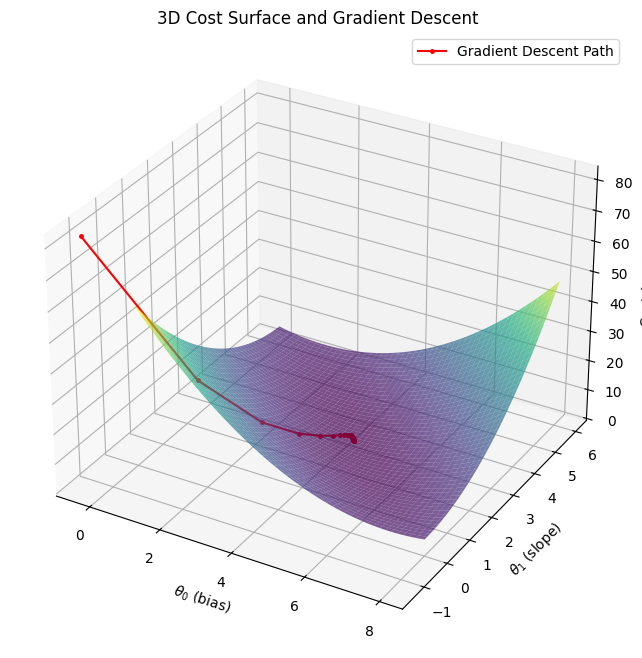

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Generate synthetic data
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Add intercept term (bias)
X_b = np.c_[np.ones((100, 1)), X]

# 2. Create cost function
def compute_mse(theta):
    predictions = X_b @ theta
    error = predictions - y
    return (1 / len(y)) * np.sum(error ** 2)

# 3. Generate meshgrid for θ0 and θ1
theta0_vals = np.linspace(0, 8, 100)
theta1_vals = np.linspace(0, 6, 100)
T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

# 4. Compute cost surface (MSE)
J_vals = np.array([[compute_mse(np.array([[t0], [t1]])) for t0 in theta0_vals] for t1 in theta1_vals])

# 5. Run Gradient Descent and store path
def gradient_descent_path(X_b, y, learning_rate=0.1, n_iters=50):
    m = len(y)
    theta = np.random.randn(2, 1)  # Random init
    path = [theta.copy()]
    
    for _ in range(n_iters):
        gradients = 2/m * X_b.T @ (X_b @ theta - y)
        theta -= learning_rate * gradients
        path.append(theta.copy())
        
    return theta, path

theta_final, path = gradient_descent_path(X_b, y)

# Extract path for plotting
theta0_path = [theta[0, 0] for theta in path]
theta1_path = [theta[1, 0] for theta in path]
cost_path = [compute_mse(np.array([[t0], [t1]])) for t0, t1 in zip(theta0_path, theta1_path)]

# 6. 3D Plot using plot_surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the cost surface
ax.plot_surface(T0, T1, J_vals, cmap='viridis', alpha=0.7)

# Plot the gradient descent path
ax.plot(theta0_path, theta1_path, cost_path, 'r.-', markersize=5, label='Gradient Descent Path')

ax.set_xlabel(r'$\theta_0$ (bias)')
ax.set_ylabel(r'$\theta_1$ (slope)')
ax.set_zlabel('Cost (MSE)')
ax.set_title('3D Cost Surface and Gradient Descent')
ax.legend()
plt.show()
